[https://github.com/ubc-vision/image-matching-benchmark](https://github.com/ubc-vision/image-matching-benchmark)

In [4]:
import sys
sys.path.insert(0,'../MPSE')
# sys.path.insert(0,'../mpse-gan')
sys.path.insert(0,'../image-matching-benchmark/third_party')

import numpy as np
from colmap.scripts.python.read_write_model import read_model, qvec2rotmat
from colmap.scripts.python.read_dense import read_array
import os
import cv2
import plotly.express as px
import deepdish as dd
import h5py
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance_matrix
from utils import *
from sklearn.preprocessing import MinMaxScaler

from MPSE import mview

src = os.path.join('data', 'reichstag')

In [5]:
# load reconstruction from colmap
cameras, imgs_meta, points = read_model(path=os.path.join(src, 'dense', 'sparse'), ext='.bin')
indices = [i for i in cameras]

print(f'Cameras: {len(cameras)}')
print(f'Images: {len(indices)}')
# print(f'3D points: {len(points)}')

Cameras: 75
Images: 75


In [6]:
def get_image(idx):
    im = cv2.imread(os.path.join(src, 'dense', 'images', imgs_meta[idx].name))
    depth = read_array(os.path.join(src, 'dense', 'stereo', 'depth_maps', imgs_meta[idx].name + '.photometric.bin'))
    min_depth, max_depth = np.percentile(depth, [5, 95])
    depth[depth < min_depth] = min_depth
    depth[depth > max_depth] = max_depth

    # reformat data
    q = imgs_meta[idx].qvec
    R = qvec2rotmat(q)
    T = imgs_meta[idx].tvec
    p = imgs_meta[idx].xys
    pars = cameras[idx].params
    K = np.array([[pars[0], 0, pars[2]], [0, pars[1], pars[3]], [0, 0, 1]])
    pids = imgs_meta[idx].point3D_ids
    v = pids >= 0
#     print('Number of (valid) points: {}'.format((pids > -1).sum()))
#     print('Number of (total) points: {}'.format(v.size))
    
    # get also the clean depth maps
    with h5py.File(os.path.join(src, 'dense', 'stereo', 'depth_maps_clean_300_th_0.10', '.'.join(imgs_meta[idx].name.split('.')[:-1]) + '.h5'), 'r') as f:
        depth_clean = f['depth'][:]

    return {
        'image': im,
        'depth_raw': depth,
        'depth': depth_clean,
        'K': K,
        'q': q,
        'R': R,
        'T': T,
        'xys': p,
        'ids': pids,
        'valid': v
    }

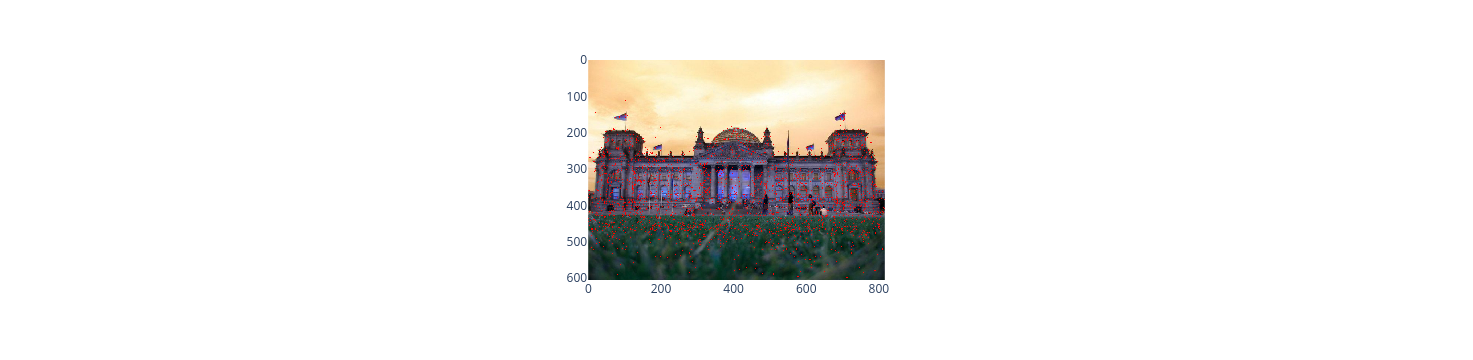

In [7]:
selected_idx = indices[0]
selected_meta = imgs_meta[selected_idx]
selected_img = get_image(selected_idx)
pointed_img = selected_img['image'].copy()

for point in selected_meta.xys:
    cv2.circle(pointed_img, point.astype('int'), 0, (255,0,0), 2)

px.imshow(pointed_img)

In [8]:
# each pair contains [bbox1, bbox2, visibility1, visibility2, # of shared matches]
pairs = dd.io.load(os.path.join(src, 'dense', 'stereo', 'pairs-dilation-0.00-fixed2.h5'))

# Threshold at a given value
# pairs[p][0]: ratio between the area of the bounding box containing common points and that of image 1
# pairs[p][1]: same for image 2
th = 0.3

filtered = []
for p in pairs:
    if pairs[p][0] >= th and pairs[p][1] >= th:
        idx1, idx2 = p
        # print(f'Valid pair: ({idx1}, {idx2}), ths=({pairs[p][2]:.2f}, {pairs[p][3]:.2f})')
        filtered += [p]
print(f'Valid pairs: {len(filtered)}/{len(pairs)}')
pairs_point_idxs = np.array(filtered)

Valid pairs: 1120/2775


In [11]:
imgs_with_common_points = list(set(pairs_point_idxs[:, 0].tolist()).union(set(pairs_point_idxs[:, 1].tolist())))
selected_imgs = imgs_with_common_points[:5]

data = [get_image(idx) for idx in selected_imgs]
v = [d['ids'][d['ids'] > 0] for d in data]
common = v[0]
for vi in v[1:]: # Taking 4 images gives 265 common points
#     print("Commons: ", len(common))
    common = np.intersect1d(common, vi)
print(f"In common of {len(data)} images: {len(common)}")

curs = np.array([points[p].xyz for p in common])

# # Project them separately onto each image
depths = [d['depth'] for d in data]
Ks = [d['K'] for d in data]
Rs = [d['R'] for d in data]
Ts = [d['T'] for d in data]

p_projs = np.array([    (np.dot(K, np.dot(R, curs.T) + T[..., None]))     for K, R, T in zip(Ks, Rs, Ts)])
p_projs = np.array([p_proj / p_proj[2, :] for p_proj in p_projs])

p_projs.shape

In common of 5 images: 192


(5, 3, 192)

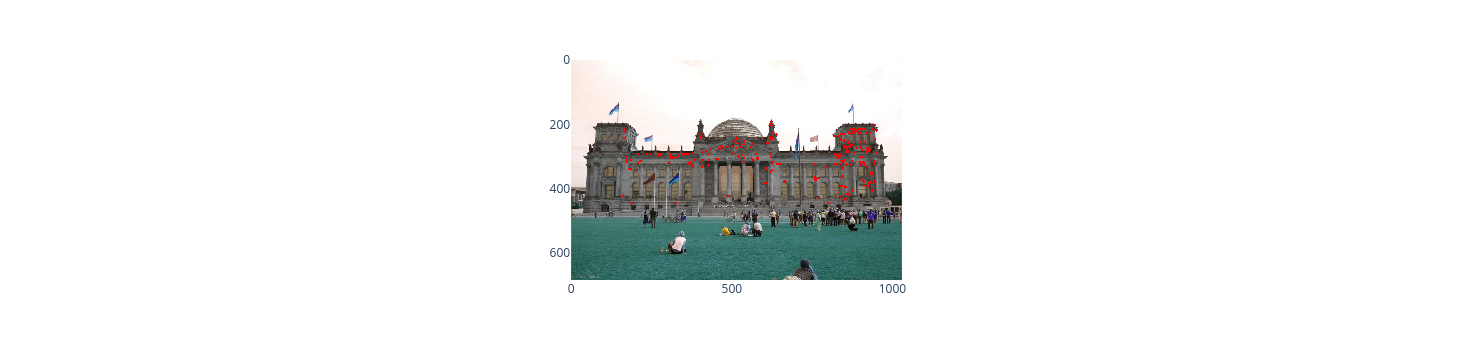

In [8]:
vis_idx = 1
img = data[vis_idx]['image'].copy()
for point in p_projs[vis_idx].T[:,:2]:
    cv2.circle(img, point.astype('int'), 1, (255,0,0), 5)

px.imshow(img)

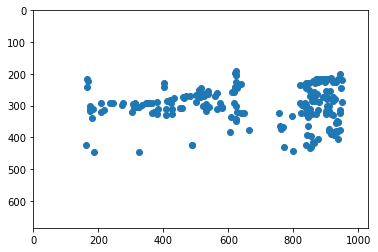

In [9]:
plt.scatter(x=p_projs[vis_idx].T[:, 0].astype('int'), y=p_projs[vis_idx].T[:,1].astype('int'))
plt.xlim([0, data[vis_idx]['image'].shape[1]])
plt.ylim([data[vis_idx]['image'].shape[0], 0])
plt.show()

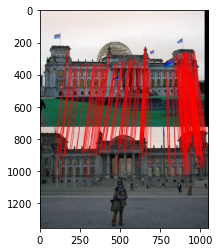

In [10]:
vis_imgs = (3, 0)

data1 = data[vis_imgs[0]]
data2 = data[vis_imgs[1]]

if data1['image'].shape[1] > data2['image'].shape[1]:
    data2['image'] = cv2.copyMakeBorder(data2['image'], 0, 0, 0, data1['image'].shape[1]-data2['image'].shape[1], cv2.BORDER_CONSTANT)
elif data1['image'].shape[1] < data2['image'].shape[1]:
    data1['image'] = cv2.copyMakeBorder(data1['image'], 0, 0, 0, data2['image'].shape[1]-data1['image'].shape[1], cv2.BORDER_CONSTANT)
vis = np.concatenate((data1['image'], data2['image']), axis=0)

img1 = data1['image'].copy()
img2 = data2['image'].copy()
for p1, p2 in zip(p_projs[vis_imgs[0]].T, p_projs[vis_imgs[1]].T):
    vis = cv2.line(vis, (p1[0].astype('int'),p1[1].astype('int')), (p2[0].astype('int'),p2[1].astype('int')+img1.shape[0]), (255,0,0), 2)
    
plt.imshow(vis)

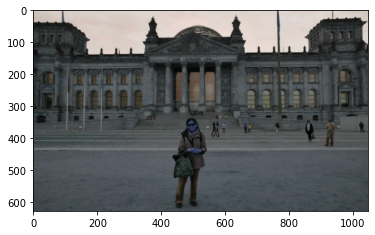

In [11]:
plt.imshow(data[0]['image'])

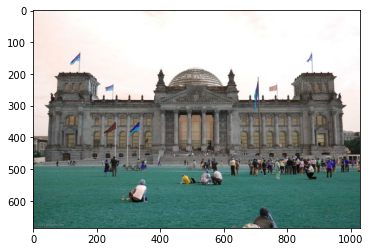

In [12]:
plt.imshow(data[1]['image'])

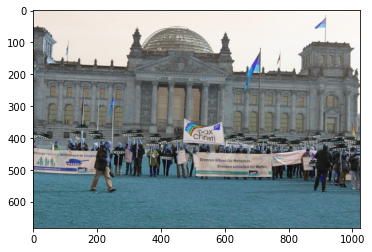

In [13]:
plt.imshow(data[2]['image'])

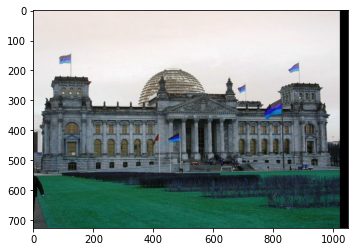

In [14]:
plt.imshow(data[3]['image'])

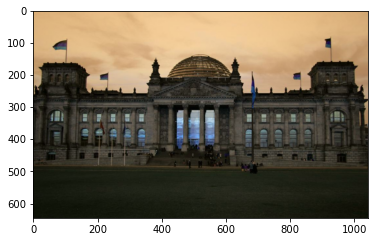

In [15]:
plt.imshow(data[4]['image'])

In [16]:
dist_mats = np.array([distance_matrix(ps[:2,:].T, ps[:2,:].T) for ps in p_projs])

mview.MPSE():
  data details:
    number of perspectives : 5
    number of samples : 192
  visualization details:
    embedding dimension : 3
    image dimension : 2
    visualization type : mds
  setup visualization instance for perspective 1 :
    mview.MDS():
      data details:
        number of samples : 192
        weighted : False
      embedding details:
        embedding dimension : 2
    initial embedding : random
    initial stress : 4.26e+02
  setup visualization instance for perspective 2 :
    mview.MDS():
      data details:
        number of samples : 192
        weighted : False
      embedding details:
        embedding dimension : 2
    initial embedding : random
    initial stress : 3.57e+02
  setup visualization instance for perspective 3 :
    mview.MDS():
      data details:
        number of samples : 192
        weighted : False
      embedding details:
        embedding dimension : 2
    initial embedding : random
    initial stress : 4.41e+02
  setup visualiz

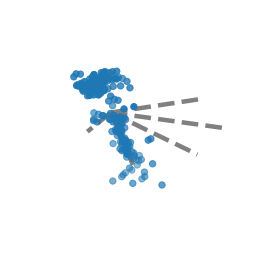

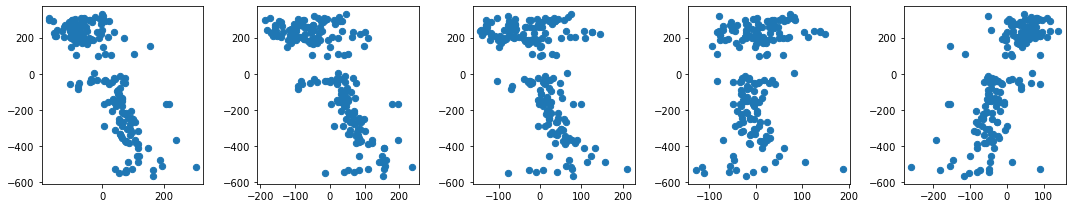

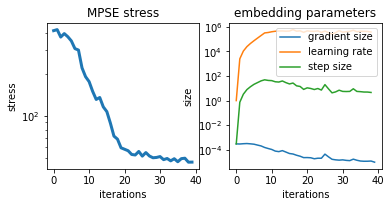

<Figure size 432x288 with 0 Axes>

In [17]:
mv = mview.basic(dist_mats,Q='cylinder',
                 batch_size = 10,
                 max_iter=300, min_grad=1e-5, min_cost=1e-5,
                 verbose=2)
mv.plot_embedding()
mv.plot_images()
mv.plot_computations()
plt.show()

embeddings1 = mv.X.copy()

In [18]:
range_xyz = [embeddings1.min(), embeddings1.max()]
plot_3D([embeddings1], range_x=range_xyz, range_y=range_xyz, range_z=range_xyz).show()